In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tampa_df = pd.read_csv ('tampa.csv')
read_dis_df = pd.read_csv ('disasters.csv')

/tmp/ipykernel_175398/2338495120.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Declaration Date'] = pd.to_datetime(filtered_df['Declaration Date'])


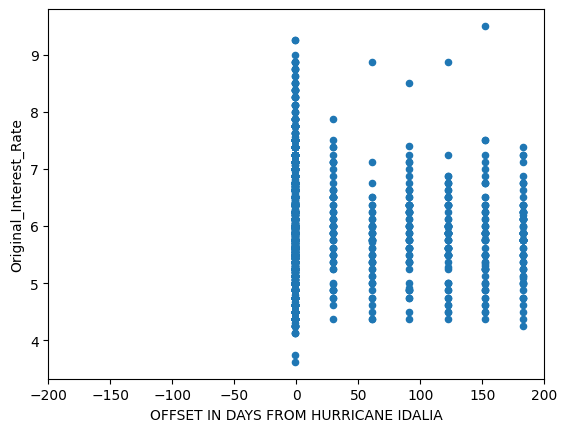

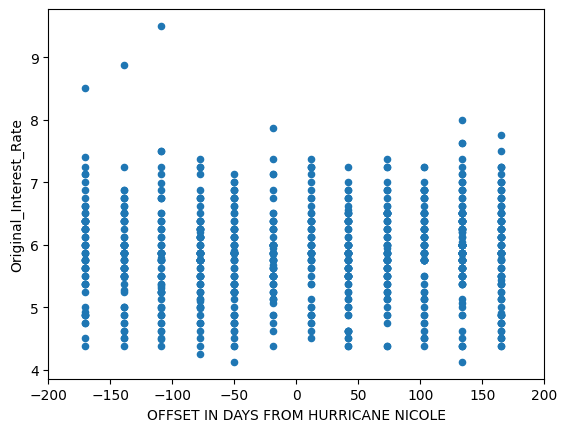

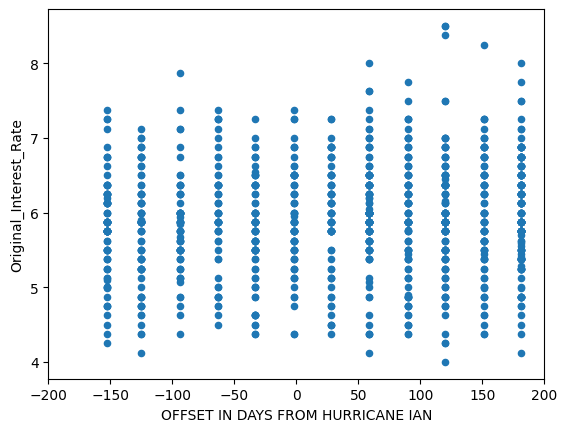

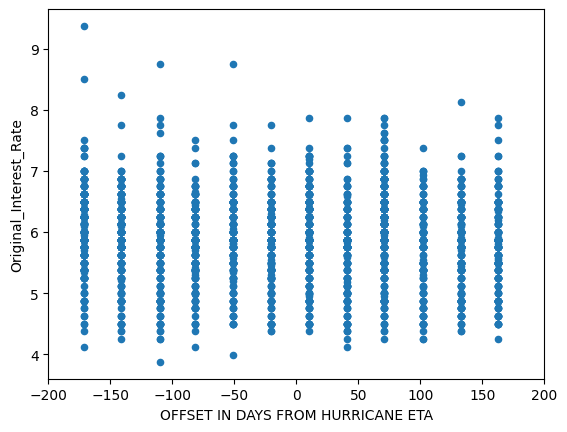

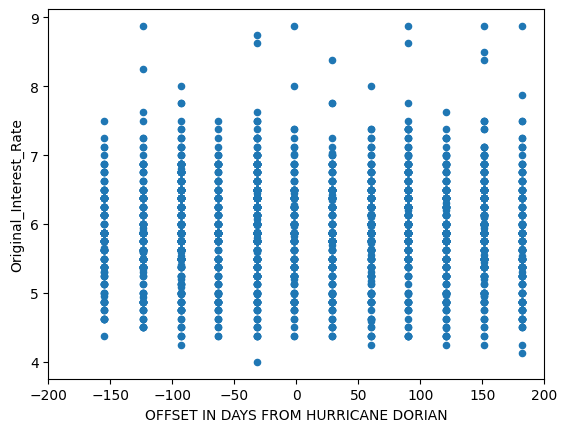

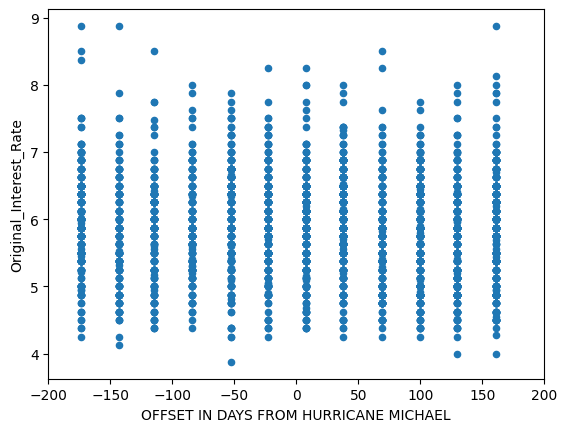

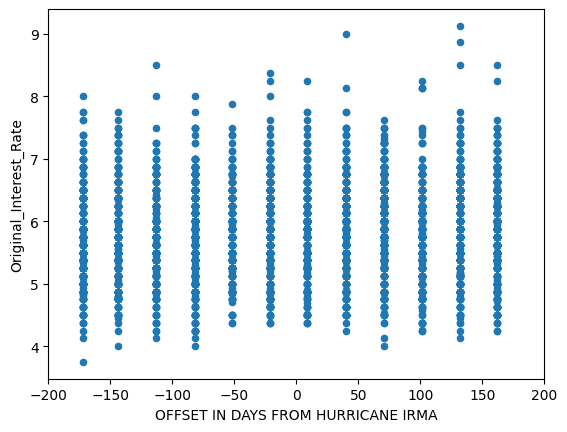

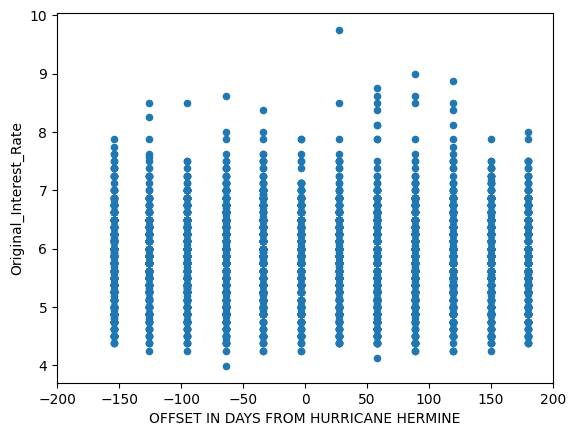

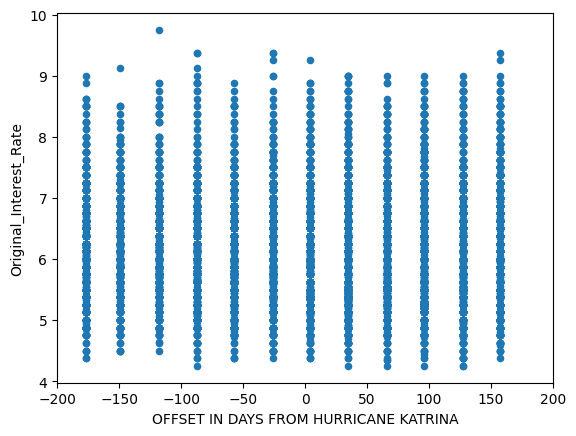

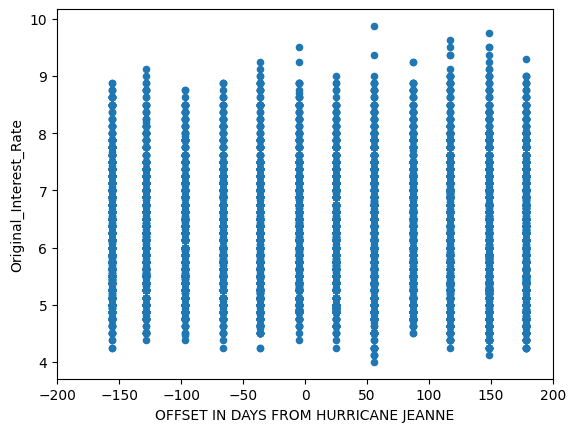

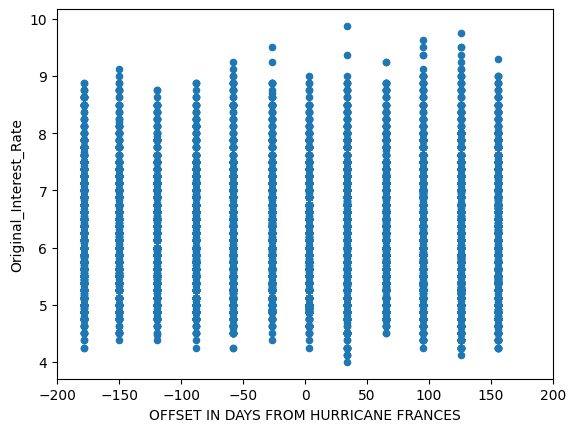

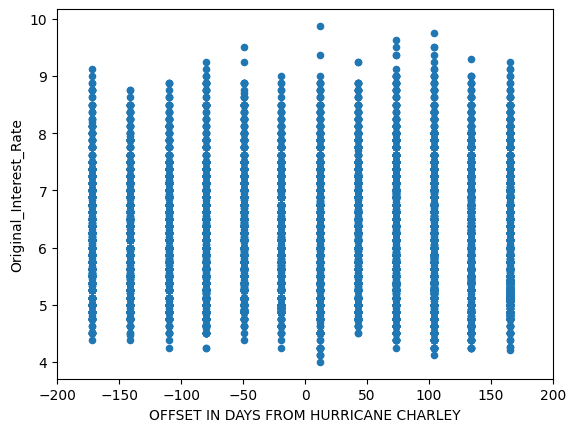

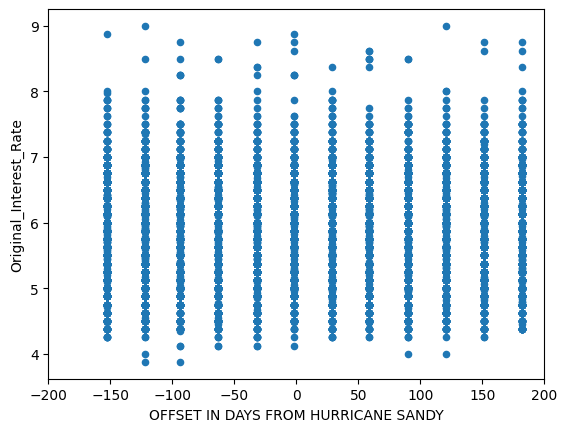

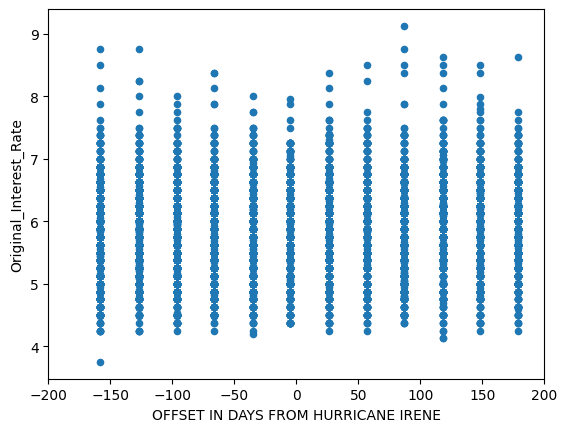

In [75]:
# filter to match what is in the city
counties = ['Hillsborough County', 'Pinellas County']
filtered_df = read_dis_df[read_dis_df['County'].isin(counties)]

# filter it so it doesn't go less than min year in tampa
filtered_df['Declaration Date'] = pd.to_datetime(filtered_df['Declaration Date'])
min_year = tampa_df['PayYear'].min()
filtered_df = filtered_df[filtered_df['Declaration Date'].dt.year >= min_year]

# get all unique hurricane names
hurricane_names = filtered_df['Declaration Title'].str.extract(r'(HURRICANE\s+\w+)', expand=False).dropna()
hurricane_names = hurricane_names.unique()

disaster_df = pd.DataFrame({'hurricanes': hurricane_names})

# Create a dictionary mapping Hurricane names to Declaration Dates
hurricane_date_mapping = {}

for hurricane_name in disaster_df['hurricanes']:
    # Find matching Declaration Titles (considering variations)
    matching_titles = filtered_df[filtered_df['Declaration Title'].str.contains(hurricane_name, case=False)]['Declaration Title']
    if not matching_titles.empty:
        # Use the first matching Declaration Date
        hurricane_date_mapping[hurricane_name] = filtered_df.loc[filtered_df['Declaration Title'] == matching_titles.iloc[0], 'Declaration Date'].values[0]

# add in declaration date to new df
disaster_df['date'] = pd.to_datetime(disaster_df['hurricanes'].map(hurricane_date_mapping))

# add 6 months prior and after
disaster_df['-6 months'] = disaster_df['date'] - pd.DateOffset(months=6)
disaster_df['+6 months'] = disaster_df['date'] + pd.DateOffset(months=6)

# convert tampa data to date
tampa_df['date'] = pd.to_datetime(dict(year=tampa_df['PayYear'], month=tampa_df['PayMonth'], day=1))

# go through each hurricane
for x in range(0, len(disaster_df)):
    curr_date = disaster_df.loc[x, 'date']
    start = disaster_df.loc[x, '-6 months']
    end = disaster_df.loc[x, '+6 months']
    hurricane = disaster_df.loc[x, 'hurricanes']

    # now for housing data
    mask = (tampa_df['date'] >= start) & (tampa_df['date'] <= end)
    filter_df = tampa_df[mask]
    scatter_df = filter_df
    scatter_df.loc[:, 'offset'] = curr_date - filter_df['date']
    scatter_df.loc[:, 'Offset from Hurricane'] = scatter_df['offset'].dt.days

    housing_info = 'Original_Interest_Rate'

    data = scatter_df
    ax = data.plot.scatter(x='Offset from Hurricane', y=housing_info)
    ax.set_xlim(left=-200, right=200)
    plt.xlabel('OFFSET IN DAYS FROM ' + hurricane)